# Автор Майя Котыга

## Установка и импорт библиотек

In [ ]:
import gdown
import pandas as pd
import base64
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from io import BytesIO
from tqdm.notebook import tqdm

## Загрузка данных

In [ ]:
url = 'https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk'
output = 'file.csv'

gdown.download(url, output, quiet=False)

data = pd.read_csv('file.csv')

Downloading...
From (original): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk
From (redirected): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk&confirm=t&uuid=d9831fa2-5f2d-4b97-bcc3-a986bd65e1f3
To: /content/file.csv
100%|██████████| 672M/672M [00:18<00:00, 37.2MB/s]


In [ ]:
data.head(2)

,Unnamed: 0,Name,WikiData,City,Lon,Lat,description,image,en_txt
0,0,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are two people that are standing on a tr...
1,1,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a blue and white exterior...


In [ ]:
def get_image(data):
  image = Image.open(BytesIO(base64.b64decode(data))).convert('RGB')
  return image

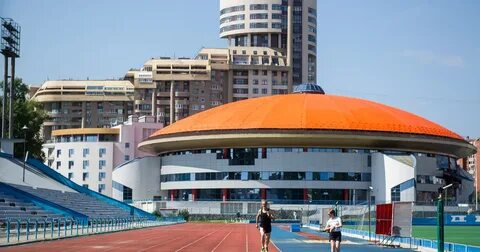

In [ ]:
get_image(data['image'][0])

In [ ]:
def get_wikipedia_links(wikidata_id):
    url = f"https://www.wikidata.org/wiki/{wikidata_id}"

    response = requests.get(url)

    if response.status_code != 200:
        print(f"{wikidata_id}. Ошибка при получении данных: {response.status_code}")
        return None

    soup = BeautifulSoup(response.text, 'html.parser')

    links = {}

    for item in soup.select('.wikibase-sitelinkview-page'):
        site = item.find('a').get('title')
        link = item.find('a').get('href')
        if 'https://ru.wikipedia.org/wiki/' in link:
          links[site] = link

    return links

In [ ]:
wikidata_ids = data['WikiData'].unique()
wiki_links = []
wiki_data = []
for wikidata_id in tqdm(wikidata_ids):
    links = get_wikipedia_links(wikidata_id)
    if links:
        for site, link in links.items():
          wiki_links.append(link)
          wiki_data.append(wikidata_id)
    else:
      wiki_links.append(None)
      wiki_data.append(wikidata_id)

  0%|          | 0/297 [00:00<?, ?it/s]

nan. Ошибка при получении данных: 404


In [ ]:
data_with_links = pd.DataFrame({'WikiData': wiki_data, 'wiki_links': wiki_links})

In [ ]:
data_with_links[data_with_links['wiki_links'].isna()]

,WikiData,wiki_links
206,NaN,None
209,Q30913943,None
210,Q28056804,None
213,Q4504600,None


In [ ]:
def fetch_wikipedia_page(url, section_ids=['История', 'Архитектура']):
    global temp
    global slice_arr
    global int_idx
    global h2_idx
    global headers
    if url == None:
      return [None] * len(section_ids)

    else:
      response = requests.get(url)

      if response.status_code != 200:
          print(f"Ошибка при получении страницы: {response.status_code}")
          return None

      soup = BeautifulSoup(response.text, 'html.parser')

      h2_idx = []
      int_idx = []
      context = soup.find_all(True)
      headers = []
      count = 0
      for section in section_ids:
        for i, tag in enumerate(context):
            if tag.name == 'h2':
                h2_idx.append(i)
                headers.append(tag.get_text(strip=True))
                if tag.get_text(strip=True).startswith(section):
                  int_idx.append(i)
                  count += 1
        if count == len(context):
          int_idx.append(None)
          count = 0

      h2_idx = sorted(list(set(h2_idx)))
      headers = list(set(headers))

      slice_arr = []
      count = 0
      for i in range(len(int_idx)):
        for j in range(len(h2_idx)):
          if int_idx[i] == h2_idx[j]:
            slice_arr.append([int_idx[i], h2_idx[j+1]])
            s =+ 1
        if s == len(h2_idx):
          slice_arr.append([None, None])
          count = 0

      temp = []
      for i in range(len(slice_arr)):
        if slice_arr[i][1] != None:
          temp.append(context[slice_arr[i][0]: slice_arr[i][1]])
        else: temp.append(None)

      text_list = [None] * len(section_ids)
      block_list = []
      for i, block in enumerate(temp):
        if block != None:
          for tag in block:
            if tag.name == 'p':
              block_list.append(tag.get_text(strip=True))
          text_list[i] = ' '.join(block_list)
          block_list = []
      return text_list

In [ ]:
wiki_text = []
for url in tqdm(wiki_links):
  wiki_text.append(fetch_wikipedia_page(url))

  0%|          | 0/297 [00:00<?, ?it/s]

In [ ]:
new_columns_df = pd.DataFrame(wiki_text, columns=['История', 'Архитектура'])
result_df = pd.concat([data_with_links, new_columns_df], axis=1)

In [ ]:
result_df.to_csv('data.csv')

# Обогащение через LLM

In [ ]:
!pip install -q torch transformers accelerate bitsandbytes >> logger.txt

In [ ]:
# !pip install datasets

In [ ]:
model_name_1 = 'Qwen/Qwen2.5-1.5B'
model_name_2 = "MTSAIR/Cotype-Nano"
model_name_3 = 'HuggingFaceH4/zephyr-7b-beta'
model_name_4 = 'VityaVitalich/Llama3.1-8b-instruct'

In [ ]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig


quant = True

if quant:
  bnb_config = BitsAndBytesConfig(
      load_in_4bit=True,
      bnb_4bit_use_double_quant=True,
      bnb_4bit_quant_type="nf4",
      bnb_4bit_compute_dtype=torch.bfloat16,

  )
  model = AutoModelForCausalLM.from_pretrained(model_name_4, quantization_config=bnb_config, device_map='cuda')
  tokenizer = AutoTokenizer.from_pretrained(model_name_4)

llm = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
data = pd.read_csv('/content/data (2).csv')

In [ ]:
data.head(1)

,Unnamed: 0,WikiData,wiki_links,История,Архитектура
0,0,Q37996725,https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D0%...,В сентябре 1929 годаЦК ВКП(б)было принято пост...,"Здание спортклуба, напоминающее корабль, имеет..."


In [ ]:
prompt = []
for i, row in tqdm(enumerate(data.iloc[:,-2:].itertuples(index=False)), total=data.shape[0]):
  prompt.append( f"""Сейчас тебе поступят тексты с историей и архитектурой достопримечательности. Красиво и кратко суммаризируй тексты на русском, убери скобки и ненужные чичла в них, чтобы это выглядело в стиле туристического гида.
  История: {row[0]}
  Архитектура: {row[1]}""")

  0%|          | 0/297 [00:00<?, ?it/s]

In [ ]:
# from datasets import Dataset
# dataset = Dataset.from_dict({"questions": prompt})
#
# def generate_response(batch):
#     responses = llm(batch["questions"], pad_token_id=llm.tokenizer.eos_token_id)
#     for i, response in enumerate(responses):
#       with open(f"/content/texts/{i}.txt", 'w+') as f:
#             generated_text = response[0]['generated_text']
#             f.write(generated_text)
#
#     return {"responses": [response[0]['generated_text'] for response in responses]}
# results = dataset.map(generate_response, batched=True, batch_size=1)

In [ ]:
llm_ans = []
for i, row in tqdm(enumerate(prompt), total=len(prompt)):
  message = [{"role": "user", "content": row}]
  ans = llm(message, pad_token_id=llm.tokenizer.eos_token_id)[0]['generated_text']
  with open(f"/content/texts/{i}.txt", 'w+') as f:
    f.write(ans)
  llm_ans.append(ans)

In [ ]:
import os
import glob

directory_path = '/content/content/texts'

for file_path in glob.glob(os.path.join(directory_path, '*.txt')):
    file_name = os.path.basename(file_path)
    new_file_name = file_name

    parts = new_file_name.split('.txt')
    base_name = parts[0]

    if len(base_name) == 1:
        new_file_name = base_name.replace(base_name, '00' + base_name)
    elif len(base_name)  == 2:
        new_file_name = base_name.replace(base_name, '0' + base_name)

    if new_file_name != file_name:
        new_file_path = os.path.join(directory_path, new_file_name + '.txt')
        os.rename(file_path, new_file_path)

In [ ]:
import os
import glob

file_paths = sorted(glob.glob(os.path.join(directory_path, '*.txt')))

file_contents = []
for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
        file_contents.append(content)

In [ ]:
file_contents[0]

'**История**\n\nВ 1929 году ЦК ВКП(б) принял постановление "О физкультурном движении", которое положило начало массовому строительству спортивных сооружений и организации спортивных сообществ в городах СССР. В Свердловске на берегу городского пруда был заложен стадион на 6400 зрителей в качестве домашней арены спортивного сообщества "Динамо". В 1931 году архитектор В. Д. Соколов начал проектирование спортклуба и водной станции, расположенных рядом со стадионом.\n\nВ 1932 году была открыта водная станция, расположенная вдоль береговой линии, а в 1934 году - спортивный клуб, известный также как "Дом физкультуры" и расположенный на стрелке пруда. До 1956 года, когда был построен Центральный стадион, спорткомплекс "Динамо" был основным местом проведения Всесоюзных республиканских и городских спортивных соревнований.\n\n**Архитектура**\n\nЗдание спортклуба напоминает корабль и имеет двухчастный объем с пешеходной галереей и вытянутыми в длину ярусными балконами в виде палуби окнами в виде и

In [ ]:
data['llm_text'] = file_contents
data.iloc[:,1:].to_csv('mipt_hackathon_data.csv', index=False)

In [ ]:
data.iloc[:,1:].head()

,WikiData,wiki_links,История,Архитектура,llm_text
0,Q37996725,https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D0%...,В сентябре 1929 годаЦК ВКП(б)было принято пост...,"Здание спортклуба, напоминающее корабль, имеет...",**История**\n\nВ 1929 году ЦК ВКП(б) принял по...
1,Q55209768,https://ru.wikipedia.org/wiki/%D0%94%D0%BE%D0%...,Комплекс зданийДОСААФбыл расположен на месте т...,"Здания клуба, спортивного техникума и жилого д...",**История**\n\nВ этом районе находился толкучи...
2,Q55154121,https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%...,В 1894 году выходцы из купеческих семей Андрей...,Комплекс зданий электростанции расположен в це...,**История**\n\nПервая городская электростанция...
3,Q55232375,https://ru.wikipedia.org/wiki/%D0%94%D0%BE%D0%...,Автором проекта являлся городской архитектор Е...,Одноэтажное кирпичное здание с цокольным этажо...,Дом купца Скрябина.\n\nВ центре Екатеринбурга ...
4,Q4306077,https://ru.wikipedia.org/wiki/%D0%9B%D0%B8%D1%...,"В 1910—1912 годах дом, в котором теперь распол...",NaN,"Дом, где сейчас находится музей, построен в на..."


# Итоги

In [ ]:
import pandas as pd

In [ ]:
hack_data = pd.read_csv('/content/mipt_hackathon_data.csv')

In [ ]:
hack_data.head()

,WikiData,wiki_links,История,Архитектура,llm_text
0,Q37996725,https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D0%...,В сентябре 1929 годаЦК ВКП(б)было принято пост...,"Здание спортклуба, напоминающее корабль, имеет...",**История**\n\nВ 1929 году ЦК ВКП(б) принял по...
1,Q55209768,https://ru.wikipedia.org/wiki/%D0%94%D0%BE%D0%...,Комплекс зданийДОСААФбыл расположен на месте т...,"Здания клуба, спортивного техникума и жилого д...",**История**\n\nВ этом районе находился толкучи...
2,Q55154121,https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%...,В 1894 году выходцы из купеческих семей Андрей...,Комплекс зданий электростанции расположен в це...,**История**\n\nПервая городская электростанция...
3,Q55232375,https://ru.wikipedia.org/wiki/%D0%94%D0%BE%D0%...,Автором проекта являлся городской архитектор Е...,Одноэтажное кирпичное здание с цокольным этажо...,Дом купца Скрябина.\n\nВ центре Екатеринбурга ...
4,Q4306077,https://ru.wikipedia.org/wiki/%D0%9B%D0%B8%D1%...,"В 1910—1912 годах дом, в котором теперь распол...",NaN,"Дом, где сейчас находится музей, построен в на..."


In [ ]:
hack_data.isna().sum()

,0
WikiData,1
wiki_links,4
История,52
Архитектура,236
llm_text,0
